<a href="https://colab.research.google.com/github/Chang365/ESAA-25-1-assignments/blob/main/ESAA_25_2_1107_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <딥러닝 파이토치 교과서> 2장 p.69-87

## 2.4 파이토치 코드 맛보기

In [19]:
# 필요한 라이브러리 호출
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
# 2-2 데이터 호출
dataset = pd.read_csv("car_evaluation.csv")
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<Axes: ylabel='count'>

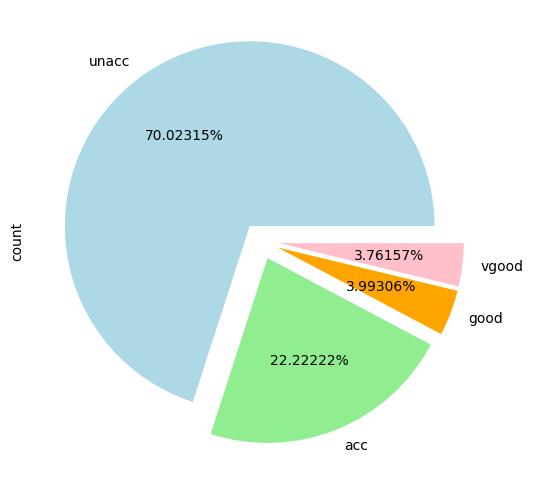

In [21]:
# 2-3 예제 데이터셋 분포
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind="pie", autopct = '%0.05f%%',
                                   colors=['lightblue', 'lightgreen', 'orange', 'pink'],
                                   explode = [0.1, 0.1, 0.1, 0.1])

- 대부분의 자동차는 허용 불가능한 상태
- 단어를 숫자(텐서)로 변환

** 범주형 데이터를 텐서로 변환**

범주형 데이터 -> dataset(category) -> 넘파이 배열 -> 텐

In [22]:
# 2-4 데이터를 범주형 타입으로 변환
# astype(): 범주 특성을 갖는 데이터를 범주형 타입으로 변환
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

In [23]:
# 2-5 배열을 텐서로 변환
categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [24]:
# 2.6 레이블로 시용할 칼럼을 탠서로 변환
outputs = pd. get_dummies (dataset . output)
outputs = outputs.values
outputs = torch. tensor( outputs) . flatten ()
print(categorical_data.shape)
print (outputs.shape)

(1728, 6)
torch.Size([6912])


- get dummies: 가변수로 만들어 주는 함수


- 워드 임베딩: 유사한 단어끼리 유사하게 인코딩되도록 표현하는 방법


In [25]:
# 2-7 범주형 칼럼을 N차원으로 변환
categorical_column_sizes = [len(dataset[column].cat.categories) for column in
                            categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in
                              categorical_column_sizes ]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [26]:
# 2-8 데이터셋 분리
total_records = 1728
test_records = int(total_records * .2) #전체 데이터 중 20%를 테스트 용도로 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [27]:
# 2-9 데이터셋 분리 확인
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [28]:
# 2-10 모델의 네트워크 생성
class Model(nn.Module): ### 1
    def __init__(self, embedding_size, output_size, layers, p=0.4): ### 2
        super().__init__() ### 3
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni,
                                     nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols #입력층의 크기를 찾기 위해 범주형 칼럼 개수를 input_size 변수에 저장

        for i in layers: ### 4
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical): ### 5
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
           embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1) #넘파이의 concatenate와 같지만 대상이 텐서
        x = self.embedding_dropout(x)
        x = self.layers(x)

        return x

1. 클래스 형태로 구현되는 모델은 nn.Module을 상속받습니다.
2. __init()__ 은 모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도로 사용하며, 객체가 생성될 때 자동으로 호출됩니다.
3. super().__init__()은 부모 클래스에 접근할 때 사용합니다.
4. 모델의 네트워크 계층을 구축하기 위해 for 문을 이용하여 각 계층을 all_layers 목록에 추가합니다.
5. foward() 함수는 학습 데이터를 입력받아서 연산을 진행합니다.


In [29]:
# 2-11 Model 클래스의 객체 생성
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [30]:
# 2-12 모델의 파라미터 정의
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
# 2-13 CPU/GPU 사용 지정
if torch.cuda.is_available():
    device = torch.device('cuda') # GPU가 있다면 GPU를 사용
else:
    device = torch.device('cpu') # GPU가 없다면 CPU를 사용

In [33]:
# 2-14 모델 학습
epochs = 500
aggregated_losses = []

# categorical_train_data를 텐서로 변환하기 전에 NumPy 배열로 다시 초기화하여
# 이전 실행으로 인해 발생할 수 있는 잠재적인 Tensor 상태를 방지합니다.
categorical_train_data = categorical_data[:total_records - test_records]
categorical_train_data = torch.from_numpy(categorical_train_data).long().to(device)

# train_outputs는 이미 텐서이므로, 올바른 장치와 데이터 타입으로 이동시킵니다.
train_outputs = train_outputs.to(device=device, dtype=torch.int64)
for i in range(epochs): # for문은 500회 반복되며, 각 반복마다 손실 함수가 오차를 계산
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss) # 반복할 때마다 오차를 aggregated_losses에 추가

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward() # 가중치를 업데이트하기 위해 손실 함수의 backward() 메서드 호출
    optimizer.step() # 옵티마이저 함수의 step() 메서드를 이용하여 기울기 업데이트


print(f'epoch: {i:3} loss: {single_loss.item():10.10f}') # 오차가 25 에포크마다 출력

epoch:   1 loss: 1.58147097
epoch:  26 loss: 1.36367750
epoch:  51 loss: 1.26279140
epoch:  76 loss: 1.19328320
epoch: 101 loss: 1.06255698
epoch: 126 loss: 0.92143464
epoch: 151 loss: 0.82813638
epoch: 176 loss: 0.75706911
epoch: 201 loss: 0.69947767
epoch: 226 loss: 0.67530721
epoch: 251 loss: 0.62913930
epoch: 276 loss: 0.61865157
epoch: 301 loss: 0.61811370
epoch: 326 loss: 0.59691137
epoch: 351 loss: 0.59887469
epoch: 376 loss: 0.58129871
epoch: 401 loss: 0.58069897
epoch: 426 loss: 0.56920487
epoch: 451 loss: 0.56767142
epoch: 476 loss: 0.57172692
epoch: 500 loss: 0.5659774542


In [35]:
# 2-15 테스트 데이터셋으로 모델 예측
categorical_test_data = torch.from_numpy(categorical_test_data).long().to(device)
test_outputs = test_outputs.to(device = device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.54346895


In [36]:
# 2-16 모델의 예측 확인
print(y_val[:5])

tensor([[ 2.2125,  1.2462, -3.2823, -3.5155],
        [ 1.4915,  0.5645, -2.2308, -2.2945],
        [ 2.3803,  1.5092, -2.8289, -2.8090],
        [ 3.1386,  2.4298, -4.4065, -4.4148],
        [ 2.6289,  1.8781, -3.8053, -3.9988]])


In [37]:
# 2-17 가장 큰 값을 갖는 인덱스 확인
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [38]:
# 2-18 테스트 데이터셋을 이용한 정확도 확인
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[255   4]
 [ 82   4]]
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       259
           1       0.50      0.05      0.09        86

    accuracy                           0.75       345
   macro avg       0.63      0.52      0.47       345
weighted avg       0.69      0.75      0.66       345

0.7507246376811594


- 성능평가지표: 정확도, 재현율, 정밀도, F1-스코어

- 정확도
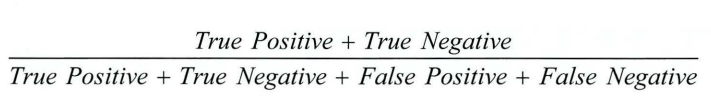

- 재현율
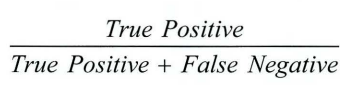

- 정밀도
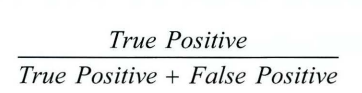

- F1-스코어
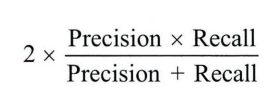